<a href="https://colab.research.google.com/github/armeh429/A-journey-for-learning-advanced-tensorflow/blob/main/Multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we'll show how you can build models with more than one output. The dataset we will be working on is available from the UCI Machine Learning Repository. It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

**Imports**

In [30]:
try: 
  %tensorflow_version 2.x
except Expection:
  pass

import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Input
from sklearn.model_selection import train_test_split

Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [31]:
def format_output(data):
  y1 = data.pop('Y1')
  yi = np.array(y1)
  y2 = data.pop('Y2')
  y2 = np.array(y2)
  return y1 , y2

def norm(x):
    return(x - train_stats['mean'])/train_stats['std']

def plot_diff(y_true , y_pred , title = ''):
  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlable('True Value')
  plt.ylable('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100, 100])
  plt.show()

def plot_metrics( metric_name ,title , ylim = 5):
  plt.title(title)
  plt.ylim(0 , ylim)
  plt.plot(history.history[metric_name],color = 'blue' , lable = metric_name)
  plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
  plt.show()

Prepare the Data

We download the dataset and format it for training

In [32]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
#use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac = 1).reset_index(drop = True)
#split the data into train and test with 80 train / 20 train
train , test = train_test_split(df , test_size = 0.2)
train_stats = train.describe()
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. [y1_output, y2_output]) when we instantiate the Model() class.

In [33]:
#Define model layers
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128',activation='relu')(first_dense)

#y1 output will be fed directly from the second dense layer
y1_output = Dense(units=1 , name= 'y1_output')(second_dense)
third_dense = Dense(units=64 , activation='relu')(second_dense)
# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)
# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          1152        input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          16512       dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
____________________________________________________________________________________________

Configure parameters

We specify the optimizer as well as the loss and metrics for each output

In [34]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Train the model 

In [35]:
#train the model for 500 epochs
history = model.fit(norm_train_X , train_Y,
                    epochs = 500 , batch_size = 10 , validation_data = (norm_test_X , test_Y))

Epoch 1/500
62/62 [==============================] - 1s 6ms/step - loss: 210.4502 - y1_output_loss: 99.8709 - y2_output_loss: 110.5793 - y1_output_root_mean_squared_error: 9.9935 - y2_output_root_mean_squared_error: 10.5157 - val_loss: 36.7541 - val_y1_output_loss: 17.2910 - val_y2_output_loss: 19.4631 - val_y1_output_root_mean_squared_error: 4.1582 - val_y2_output_root_mean_squared_error: 4.4117
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 35.7710 - y1_output_loss: 13.1795 - y2_output_loss: 22.5916 - y1_output_root_mean_squared_error: 3.6304 - y2_output_root_mean_squared_error: 4.7531 - val_loss: 25.7414 - val_y1_output_loss: 11.2060 - val_y2_output_loss: 14.5354 - val_y1_output_root_mean_squared_error: 3.3475 - val_y2_output_root_mean_squared_error: 3.8125
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 24.3079 - y1_output_loss: 9.6112 - y2_output_loss: 14.6967 - y1_output_root_mean_squared_error: 3.1002 - y2_output_root_mean_squar

Evaluate the Model and Plot Metrics

In [36]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 1.0468 - y1_output_loss: 0.4274 - y2_output_loss: 0.6194 - y1_output_root_mean_squared_error: 0.6538 - y2_output_root_mean_squared_error: 0.7871
Loss = 1.0468388795852661, Y1_loss = 0.42739084362983704, Y1_mse = 0.6537513732910156, Y2_loss = 0.6194481253623962, Y2_mse = 0.7870502471923828


AttributeError: ignored

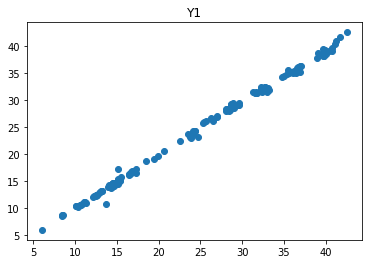

In [37]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)